In [9]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import matplotlib.pyplot as plt

In [3]:
x_min = - 600_000
x_max = 400_000
y_min = - 1_400_000
y_max = - 400_000

REDO_BEDMAP_CROP = True
# REDO_BEDMAP_CROP = False

# Takes ~5 minutes to run
if REDO_BEDMAP_CROP:
    # 82 M data points
    bedmap123 = pd.read_csv("/home/kim/data/bedmap_raw_data/bedmap123.csv")
    # Crop to the region of interest: HERE ~ 4 M subset
    bedmap123_ross = bedmap123[
        (bedmap123["x"] > x_min) & (bedmap123["x"] < x_max) & (bedmap123["y"] > y_min) & (bedmap123["y"] < y_max)]
    # Save 
    bedmap123_ross.to_csv("/home/kim/data/bedmap_raw_data/bedmap123_ross.csv", index = False)

else: 
    # Just load
    bedmap123_ross = pd.read_csv("/home/kim/data/bedmap_raw_data/bedmap123_ross.csv")

In [8]:
# 5.8 M data points
print(bedmap123_ross.shape)
bedmap123_ross.head()

(5790926, 9)


,lon,lat,x,y,s,t,b,b_inferred,source
246,-162.2167,-78.17500,-393747.895145,-1.227610e+06,43.0,257.0,-607.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
247,-163.0000,-78.78833,-357254.891928,-1.168528e+06,197.0,415.0,-218.0,True,BEDMAP1_1966-2000_AIR_BM1.csv
248,-164.8333,-78.91666,-316007.544874,-1.165778e+06,48.0,369.0,-425.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
249,-168.6500,-79.15334,-232601.272638,-1.158792e+06,59.0,384.0,-539.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
250,-171.5167,-79.11667,-174949.002700,-1.172950e+06,49.0,328.0,-695.0,False,BEDMAP1_1966-2000_AIR_BM1.csv


# Show all data in the are

(11582, 9)


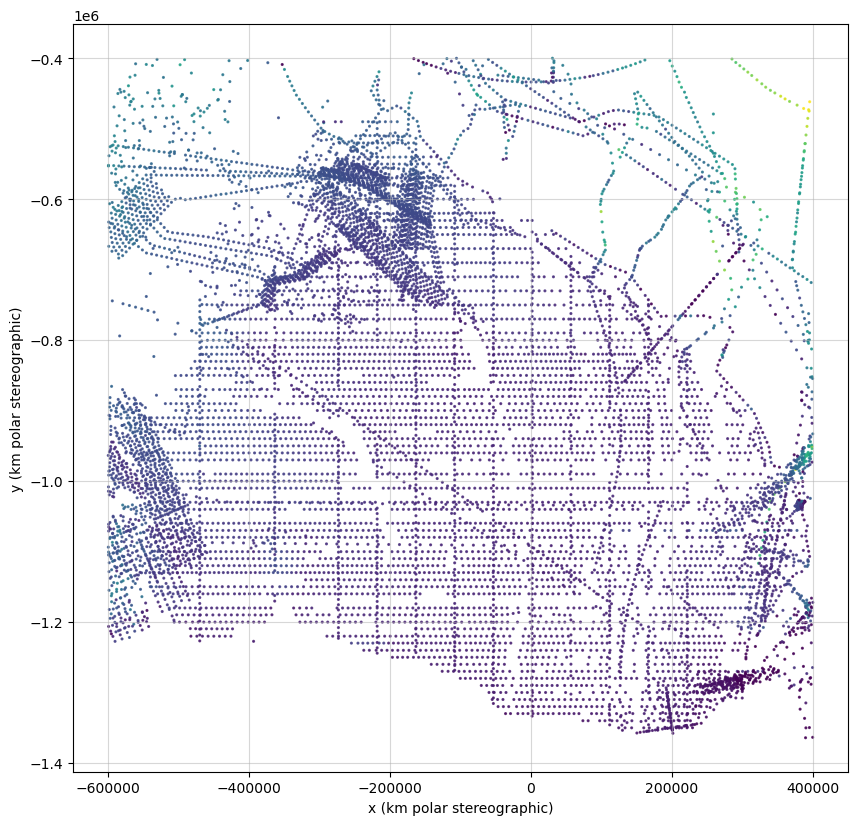

In [7]:
SUBSAMPLE_RATE = 500
# subsample to reduce number of data points
bedmap123_ross_ss = bedmap123_ross[::SUBSAMPLE_RATE]
print(bedmap123_ross_ss.shape)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    bedmap123_ross_ss['x'], 
    bedmap123_ross_ss['y'], 
    c = bedmap123_ross_ss['t'], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)

# Subset ice shelf data for training

In [10]:
tighter_ice_shelf_mask = xr.load_dataarray("data/tighter_ice_shelf_mask.nc")

In [ ]:
mask_at_points = tighter_ice_shelf_mask .interp(
    x = ("points", bedmap123_ross["x"].values),
    y = ("points", bedmap123_ross["y"].values),
    # nearest is fast
    method = "nearest"
)

# Step 2: Convert to numpy array for filtering
mask_values = mask_at_points.values

# Step 3: Subset DataFrame where mask==3
bedmap123_ross_onshelf = bedmap123_ross[mask_values == 3]

# Reduced to 3M points
print(bedmap123_ross_onshelf.shape)

(3260561, 9)


(32606, 9)


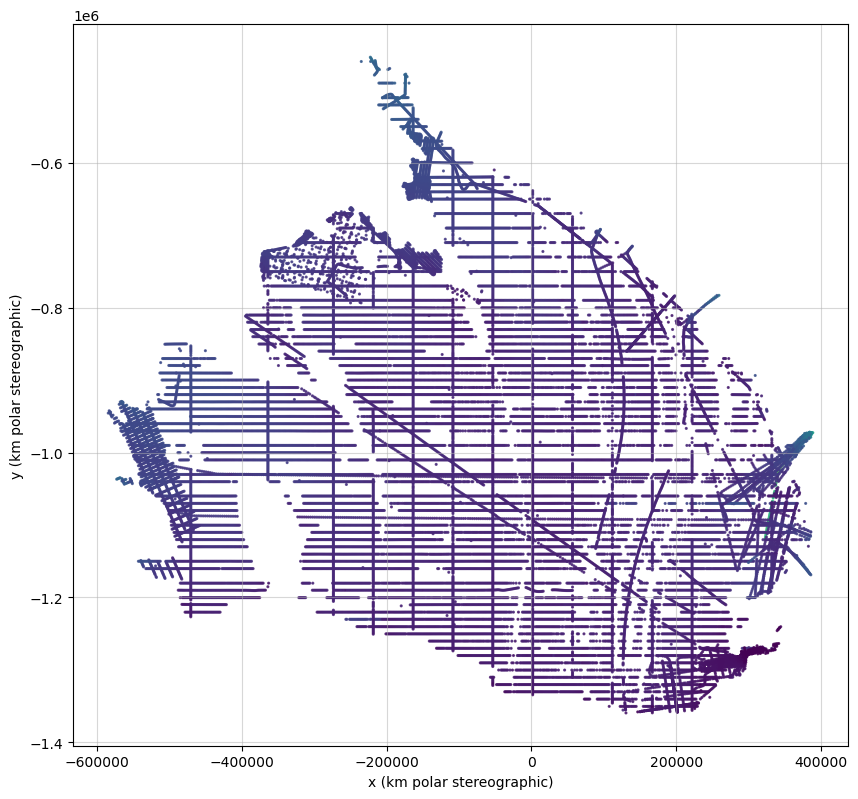

In [20]:
SUBSAMPLE_RATE = 100
# subsample to reduce number of data points
bedmap123_ross_onshelf_ss = bedmap123_ross_onshelf[::SUBSAMPLE_RATE]
print(bedmap123_ross_onshelf_ss.shape)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    bedmap123_ross_onshelf_ss['x'], 
    bedmap123_ross_onshelf_ss['y'], 
    c = bedmap123_ross_onshelf_ss['t'], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")
ax.set_aspect('equal')
plt.savefig("figures/ice_thickness_points_onshelf.png", dpi = 300, bbox_inches = "tight")
ax.grid(True, alpha = 0.5)

# Combine into flux tensors

- rescale to [0, 1]
- rescale fluxes
- remove nans

## Firn correction

In [21]:
# Load meta data which contains firn adjustment info
meta = pd.read_csv("/home/kim/data/bedmap_raw_data_test/bedmap123_metadata.csv")

# Extract float
meta["firn_correction"] = meta.firn.str.extract(r"([-+]?\d*\.?\d+)").astype(float)
# Replace -9999 with 0.0 (We assume this means "zero" adjustment applied so far.)
meta["firn_correction"] = meta["firn_correction"].replace(-9999, 0.0)
# Calculate remaining delta (we correct all data to have a firn correction of 10)
# t_corrected = t_observed - 10

UNIVERSAL_FIRN_CORRECTION = 10.0
meta["firn_correction_delta"] = meta["firn_correction"] - UNIVERSAL_FIRN_CORRECTION

# Create lookup dictionary from meta
firn_delta_lookup = dict(zip(meta["source"], meta["firn_correction_delta"]))

# Add the correction delta to the thickness points
# NOTE: Create fa (firn adjusted) variable
bedmap123_ross_onshelf["t_fa"] = (
    bedmap123_ross_onshelf["t"] + bedmap123_ross_onshelf["source"].map(firn_delta_lookup)
)

/tmp/ipykernel_12341/2175815482.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedmap123_ross_onshelf["t_fa"] = (


In [25]:
bedmap123_ross_onshelf.to_csv("data/bedmap123_ross_onshelf_3M.csv", index = False)